In [1]:
# being super uncreative and just using California Housing price prediction problem.

In [2]:
%load_ext autoreload
%autoreload 2

#making sure we have necessary versions
import sys
assert sys.version_info>=(3,5)
import sklearn
assert sklearn.__version__ >= "0.2" 

# user written functions to make life easier
import util

# set up matplotlib for prinitng figures
import matplotlib as mpl
mpl.rc('axes', labelsize=16) # font of x and y labels 
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import matplotlib.pyplot as plt

# imporing other necessary packages
import numpy as np
import pandas as pd

# to mute some warmings, specially while creating new features in a df
pd.options.mode.chained_assignment = None

In [3]:
# Getting and loading the data

util.download_housing_data()
housing_df = util.get_housing_data() 


California Housing data downloaded


In [4]:
housing_df.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


In [5]:
# -- Each Row represents a district.
# -- the values for Total_rooms and Total_bedrooms does not make sense to me at this point
    # - there is a variable called households, which might suggest total houses in that district, 
    #   which might mean that total_bedrooms and total_rooms are for all houses in that district,
    #   indeed very strange way to put down a house info

In [6]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
# let's see what we have for ocean_proximity
housing_df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

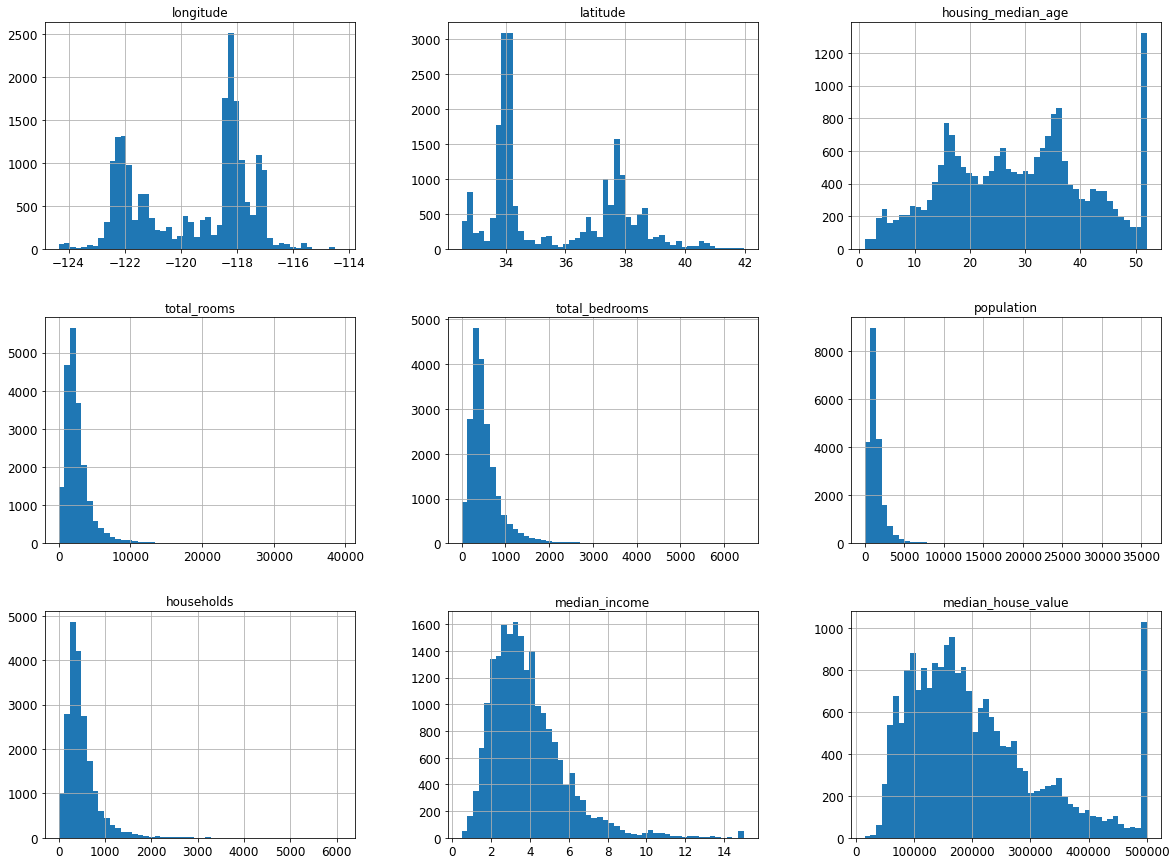

In [8]:
# As we have only 10 variables, we can just see histogram of each of them together 

housing_df.hist(bins = 50,figsize=(20,15))
plt.show()

In [9]:
# something funny with housing_median_age and median_house_value: 
#    -- some capping is done here
#    -- this does not sound good, would most likely have to remove them
# total_rooms, total_bedrooms, population and households all are right skewed. 

In [10]:
## keep some test data aside (given the size of df 20% sounds reasonable)

def split_train_test(data, test_ratio):
    '''
    Input: 
        data:pd dataframe
        test_ration: ratio of data to be kept in test set
    Output:
        two pd dataframes, first one train and second test
    '''
    shuffled_indices = np.random.permutation(len(data))
    test_data_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_data_size]
    train_indices = shuffled_indices[test_data_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]


np.random.seed(13290)
train_df, test_df = split_train_test(housing_df, 0.2)

In [11]:
print(train_df.shape)
print(test_df.shape)

(16512, 10)
(4128, 10)


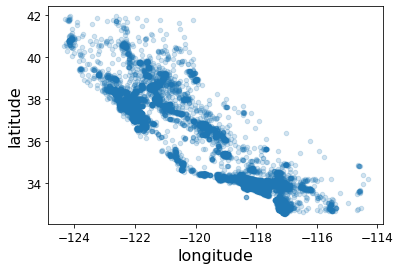

In [12]:
# Exploring data a bit more
# only work with training data now

train_df.plot(kind='scatter', x="longitude", y= "latitude", alpha=0.2)
plt.show()

In [13]:
# okay, looks like a bit of california and we seems to have sample from all around, and highly densed areas 
# have more observations (not sure why though, the data is at district level, which i think should be devided
# by geographical area, they might able be divided by population)


In [14]:
train_df.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
10105,-117.95,33.92,18.0,2825.0,660.0,1590.0,643.0,3.6106,153600.0,<1H OCEAN
15544,-117.10,33.09,5.0,12045.0,2162.0,5640.0,1997.0,4.4375,353000.0,<1H OCEAN
3363,-120.36,40.45,19.0,689.0,143.0,355.0,127.0,1.7333,70000.0,INLAND


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

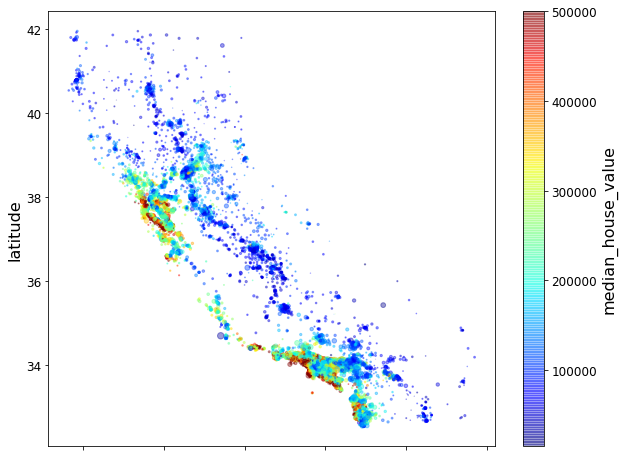

In [15]:
# lets check the house prices, with population size along with lat and long axis

train_df.plot(kind='scatter', x = "longitude", y= "latitude", alpha = 0.4,
             s=train_df['population']/300, figsize=(10,8),
             c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True)

In [16]:
# well, so houses near the sea line are surely more expensive than the ones away from sea

In [17]:
# as the dataset is not crazy big, lets do some correlation studies

corr_matrix = train_df.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924537,-0.113245,0.044929,0.068980,0.101067,0.053831,-0.010233,-0.045265
latitude,-0.924537,1.000000,0.016696,-0.035852,-0.066051,-0.109314,-0.068988,-0.084155,-0.145701
housing_median_age,-0.113245,0.016696,1.000000,-0.364139,-0.323441,-0.306911,-0.306374,-0.118932,0.104340
total_rooms,0.044929,-0.035852,-0.364139,1.000000,0.929759,0.867888,0.918528,0.203441,0.140648
total_bedrooms,0.068980,-0.066051,-0.323441,0.929759,1.000000,0.889043,0.980846,-0.001766,0.057489
population,0.101067,-0.109314,-0.306911,0.867888,0.889043,1.000000,0.916627,0.010310,-0.017676
households,0.053831,-0.068988,-0.306374,0.918528,0.980846,0.916627,1.000000,0.018402,0.073352
median_income,-0.010233,-0.084155,-0.118932,0.203441,-0.001766,0.010310,0.018402,1.000000,0.684911
median_house_value,-0.045265,-0.145701,0.104340,0.140648,0.057489,-0.017676,0.073352,0.684911,1.000000


In [18]:
# our outcome variable is median_housr_value

corr_matrix['median_house_value'].sort_values()

latitude             -0.145701
longitude            -0.045265
population           -0.017676
total_bedrooms        0.057489
households            0.073352
housing_median_age    0.104340
total_rooms           0.140648
median_income         0.684911
median_house_value    1.000000
Name: median_house_value, dtype: float64

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

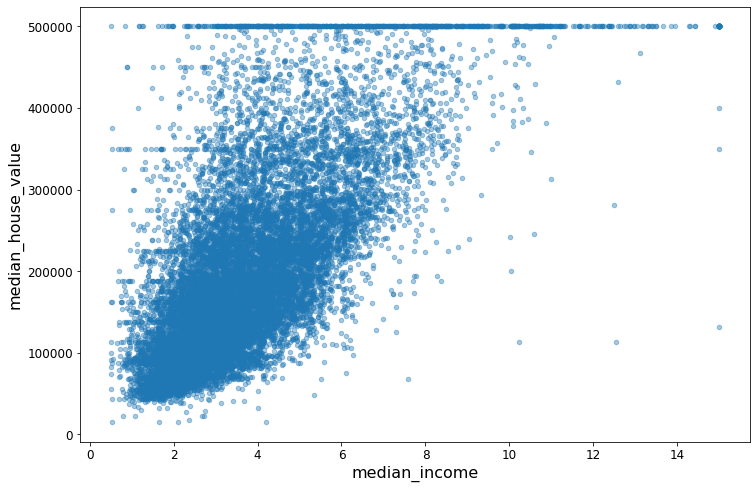

In [19]:
# okay, so as expected median income is highly correlated, rooms and house age are next, which also makes sense. 
# latitude also has some decent big effect. 

# let;s check income and house price a bit more in detail
train_df.plot(kind='scatter', x = 'median_income',  y = 'median_house_value',
             alpha=0.4, figsize=(12,8))

In [20]:
# the capping at 500k is clearly visible and has a potential to screw everything, There seems another capping ~350k
# god know what that could be. but overall, looks quite a nice linear relationship. 

In [24]:
# creating some features

train_df.name = "Training Data"
test_df.name = "Testing Data"

def add_new_features(df):
    '''
    this function will add the listed features in the input dataframe
    Input:
        df: pd dataframe of either train set or test set
        
    # FUTURE NOTE: This is still dangerous, need to find some stable method to do this
    '''
    df['rooms_per_hh'] = df['total_bedrooms'] / df['households']
    df['bedrooms_per_hh'] = df['total_bedrooms'] / df['households']
    df['population_per_hh'] = df['population'] / df['households']
    
    return print("added features in {}".format(df.name) )


add_new_features(train_df)
add_new_features(test_df) # add exact same features in test data as well

added features in Training Data
added features in Testing Data


In [27]:
# handling missing data
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [35]:
# before fixing the missing values, we would need to convert categorival variable into onehotcode

from sklearn.preprocessing import OneHotEncoder
category_encoder = OneHotEncoder()
ocean_proximity = category_encoder.fit_transform(np.array(train_df['ocean_proximity']).reshape(-1,1))
ocean_proximity.toarray()
# so, we have some missing data, we can impute them with median values, let's use sklearn simpleimputer

# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy="median")
# imputer.fit(train_df)

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])